<a href="https://colab.research.google.com/github/tigju/3D_Cube/blob/master/module3-ridge-regression/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import numpy as np
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [97]:
df.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [0]:
df.drop(['EASE-MENT', 'APARTMENT_NUMBER'], axis=1, inplace=True)

In [0]:
df = df.dropna()

In [142]:
df.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [143]:
df_subset = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)]
df_subset.head()


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [144]:
df_subset.shape

(3151, 19)

In [145]:
df_subset['SALE_DATE'] = pd.to_datetime(df_subset['SALE_DATE'], infer_datetime_format=True)
df_subset.dtypes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE                         datetime64[ns]
dtype: object

In [146]:
train = df_subset[(df_subset['SALE_DATE'] >= '2019-01-01') & (df_subset['SALE_DATE'] <= '2019-03-31')]
train.head()
train

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,5,OTHER,01 ONE FAMILY DWELLINGS,1,4081,44,A2,10 SEAFOAM STREET,10306.0,1.0,0.0,1.0,"2,400",921.0,1950.0,1,A2,330000,2019-03-29
18130,5,OTHER,01 ONE FAMILY DWELLINGS,1,2373,201,A5,74 MCVEIGH AVE,10314.0,1.0,0.0,1.0,"2,450",2128.0,1980.0,1,A5,690000,2019-03-29
18132,5,OTHER,01 ONE FAMILY DWELLINGS,1,1132,42,A1,479 VILLA AVENUE,10302.0,1.0,0.0,1.0,"4,361",1807.0,2018.0,1,A1,610949,2019-03-29
18134,5,OTHER,01 ONE FAMILY DWELLINGS,1,3395,37,A2,63 NUGENT AVENUE,10305.0,1.0,0.0,1.0,"6,000",621.0,1930.0,1,A2,520000,2019-03-29


In [147]:
test = df_subset[(df_subset['SALE_DATE'] >= '2019-04-01') & (df_subset['SALE_DATE'] <= '2019-04-30')]
test.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18235,2,OTHER,01 ONE FAMILY DWELLINGS,1,5913,878,A1,4616 INDEPENDENCE AVENUE,10471.0,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,2019-04-01
18239,2,OTHER,01 ONE FAMILY DWELLINGS,1,5488,48,A2,558 ELLSWORTH AVENUE,10465.0,1.0,0.0,1.0,"2,500",720.0,1935.0,1,A2,253500,2019-04-01
18244,3,OTHER,01 ONE FAMILY DWELLINGS,1,5936,31,A1,16 BAY RIDGE PARKWAY,11209.0,1.0,0.0,1.0,"2,880",2210.0,1925.0,1,A1,1300000,2019-04-01
18280,3,OTHER,01 ONE FAMILY DWELLINGS,1,7813,24,A5,1247 EAST 40TH STREET,11210.0,1.0,0.0,1.0,"1,305",1520.0,1915.0,1,A5,789000,2019-04-01
18285,3,OTHER,01 ONE FAMILY DWELLINGS,1,8831,160,A9,2314 PLUMB 2ND STREET,11229.0,1.0,0.0,1.0,"1,800",840.0,1925.0,1,A9,525000,2019-04-01


In [148]:
train.describe()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2507.0,2.507000e+03
mean,6758.303949,75.778221,10993.398484,0.987635,0.016354,1.003989,1473.744715,1944.766653,1.0,6.215737e+05
std,3975.909029,157.531138,494.291462,0.110532,0.129966,0.171794,599.217635,27.059337,0.0,2.916072e+05
min,21.000000,1.000000,10301.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.040000e+05
25%,3837.500000,21.000000,10314.000000,1.000000,0.000000,1.000000,1144.000000,1925.000000,1.0,4.405000e+05
50%,6022.000000,42.000000,11234.000000,1.000000,0.000000,1.000000,1368.000000,1940.000000,1.0,5.600000e+05
75%,9888.500000,70.000000,11413.000000,1.000000,0.000000,1.000000,1683.000000,1960.000000,1.0,7.500000e+05
max,16350.000000,2720.000000,11697.000000,1.000000,2.000000,3.000000,7875.000000,2018.000000,1.0,1.955000e+06


In [149]:
train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2507,2507,2507,2507,2507,2507,2507,2507,2507
unique,5,7,1,2,13,2497,887,11,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,22-40 93RD STREET,"4,000",A1,2019-01-31 00:00:00
freq,1204,2360,2507,2476,919,2,234,919,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [150]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'LAND_SQUARE_FEET', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)
features

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [0]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [152]:
y_train

44       550000
61       200000
78       810000
108      125000
111      620000
          ...  
18129    330000
18130    690000
18132    610949
18134    520000
18147    104000
Name: SALE_PRICE, Length: 2507, dtype: int64

In [0]:
import category_encoders as ce 

encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

In [154]:
X_train_enc.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0


In [167]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=15)
X_train_kbest = selector.fit_transform(X_train_enc, y_train)
X_test_kbest = selector.transform(X_test_enc)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [156]:
X_train_kbest.shape, X_test_kbest.shape

((2507, 10), (644, 10))

In [157]:
X_train_kbest

array([[1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.1230e+04, 1.3250e+03,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.1427e+04, 2.0010e+03,
        0.0000e+00],
       [0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 1.0461e+04, 2.0430e+03,
        0.0000e+00],
       ...,
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0302e+04, 1.8070e+03,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0305e+04, 6.2100e+02,
        0.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.1429e+04, 1.1630e+03,
        0.0000e+00]])

In [158]:
mask = selector.get_support()
mask

array([ True, False,  True,  True, False,  True,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False])

In [159]:
X_train_enc.columns[mask]

Index(['BOROUGH_3', 'BOROUGH_2', 'BOROUGH_5', 'NEIGHBORHOOD_OTHER',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_FOREST HILLS',
       'BUILDING_CLASS_AT_PRESENT_A3', 'ZIP_CODE', 'GROSS_SQUARE_FEET',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3'],
      dtype='object')

In [160]:
X_train_enc.columns[~mask]

Index(['BOROUGH_4', 'BOROUGH_1', 'NEIGHBORHOOD_EAST NEW YORK',
       'NEIGHBORHOOD_BEDFORD STUYVESANT', 'NEIGHBORHOOD_BOROUGH PARK',
       'NEIGHBORHOOD_ASTORIA',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A0',
       'BUILDING_CLASS_AT_PRESENT_A2', 'BUILDING_CLASS_AT_PRESENT_S1',
       'BUILDING_CLASS_AT_PRESENT_A4', 'BUILDING_CLASS_AT_PRESENT_A6',
       'BUILDING_CLASS_AT_PRESENT_A8', 'BUILDING_CLASS_AT_PRESENT_B2',
       'BUILDING_CLASS_AT_PRESENT_S0', 'BUILDING_CLASS_AT_PRESENT_B3',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE_A9',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SAL

In [161]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

mae_list = []
for k in range(1, X_train_enc.shape[1]+1):
  print(f'{k} features')
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_kbest = selector.fit_transform(X_train_enc, y_train)
  X_test_kbest = selector.transform(X_test_enc)
  model = LinearRegression()
  model.fit(X_train_kbest, y_train)
  y_pred = model.predict(X_test_kbest)
  mae = mean_absolute_error(y_pred, y_test)
  print(f'MAE on test set: ${mae:.2f}')
  mae_list.append(mae)

1 features
MAE on test set: $183640.59
2 features
MAE on test set: $182569.26
3 features
MAE on test set: $182569.26
4 features
MAE on test set: $183440.75
5 features
MAE on test set: $181935.13
6 features
MAE on test set: $176456.32
7 features
MAE on test set: $177001.36
8 features
MAE on test set: $176707.36
9 features
MAE on test set: $171663.46
10 features
MAE on test set: $170976.54
11 features
MAE on test set: $170506.83
12 features
MAE on test set: $162300.68
13 features
MAE on test set: $163558.86
14 features
MAE on test set: $162562.33
15 features
MAE on test set: $162563.55
16 features
MAE on test set: $162419.48
17 features
MAE on test set: $162419.48
18 features
MAE on test set: $162177.33
19 features
MAE on test set: $162177.33
20 features
MAE on test set: $157892.53
21 features
MAE on test set: $157965.58
22 features
MAE on test set: $157965.58
23 features
MAE on test set: $157965.58
24 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

MAE on test set: $157965.58
25 features
MAE on test set: $157696.75
26 features
MAE on test set: $157577.96
27 features
MAE on test set: $157511.01
28 features
MAE on test set: $157468.04
29 features
MAE on test set: $158331.08
30 features
MAE on test set: $158428.48
31 features
MAE on test set: $158428.48
32 features
MAE on test set: $158428.58
33 features
MAE on test set: $158083.81
34 features
MAE on test set: $158062.46
35 features
MAE on test set: $158086.12
36 features
MAE on test set: $157741.05
37 features
MAE on test set: $157741.05
38 features
MAE on test set: $158747.04
39 features
MAE on test set: $158053.12
40 features
MAE on test set: $158102.13
41 features
MAE on test set: $158117.43
42 features
MAE on test set: $158456.46
43 features
MAE on test set: $158412.83
44 features
MAE on test set: $158408.34
45 features
MAE on test set: $158405.84
46 features
MAE on test set: $158407.18
47 features
MAE on test set: $158408.64
48 features
MAE on test set: $158409.95


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

In [165]:
mae_list

[183640.5858012459,
 182569.26269991108,
 182569.26269991108,
 183440.7495182458,
 181935.13496055856,
 176456.31527301742,
 177001.36282510593,
 176707.3638317006,
 171663.45577943674,
 170976.54242961132,
 170506.8252724062,
 162300.67945631663,
 163558.86297692565,
 162562.32605108854,
 162563.54998766235,
 162419.4839808853,
 162419.4839808679,
 162177.3305601669,
 162177.33056016243,
 157892.53138233995,
 157965.58284095093,
 157965.5828409442,
 157965.58284095232,
 157965.58284094735,
 157696.75076821295,
 157577.96450353868,
 157511.01224524927,
 157468.04288544506,
 158331.07532756994,
 158428.48295705763,
 158428.48295705544,
 158428.58408982863,
 158083.80795998187,
 158062.45684893473,
 158086.11792763713,
 157741.05243301488,
 157741.05243303237,
 158747.04466092266,
 158053.1156137794,
 158102.1339662505,
 158117.4251799967,
 158456.45680673097,
 158412.82614695354,
 158408.34033487478,
 158405.83618012423,
 158407.1822835792,
 158408.6380046584,
 158409.9517177795]

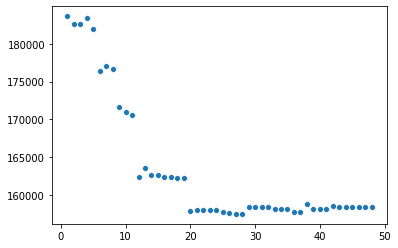

In [175]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(range(1, X_train_enc.shape[1]+1), mae_list)
plt.show()

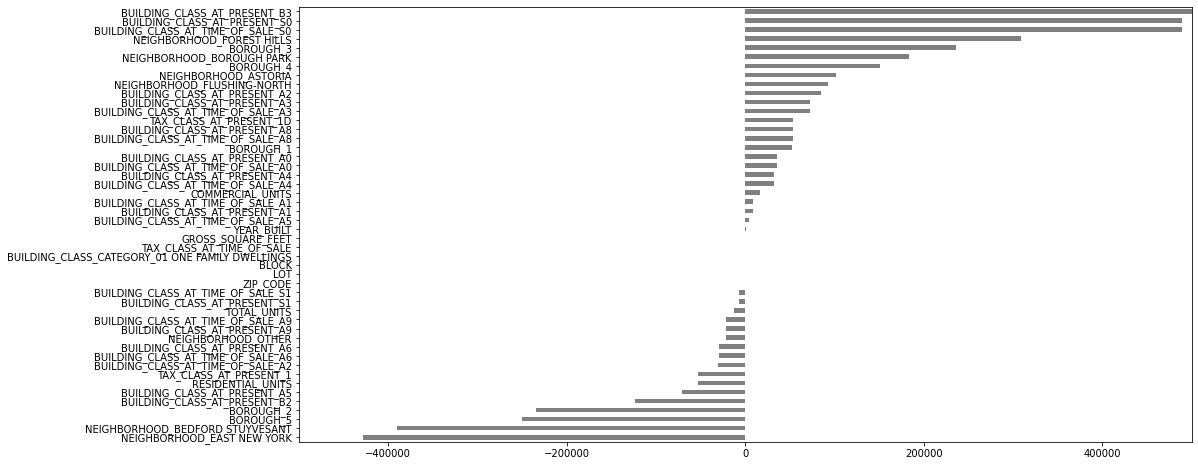

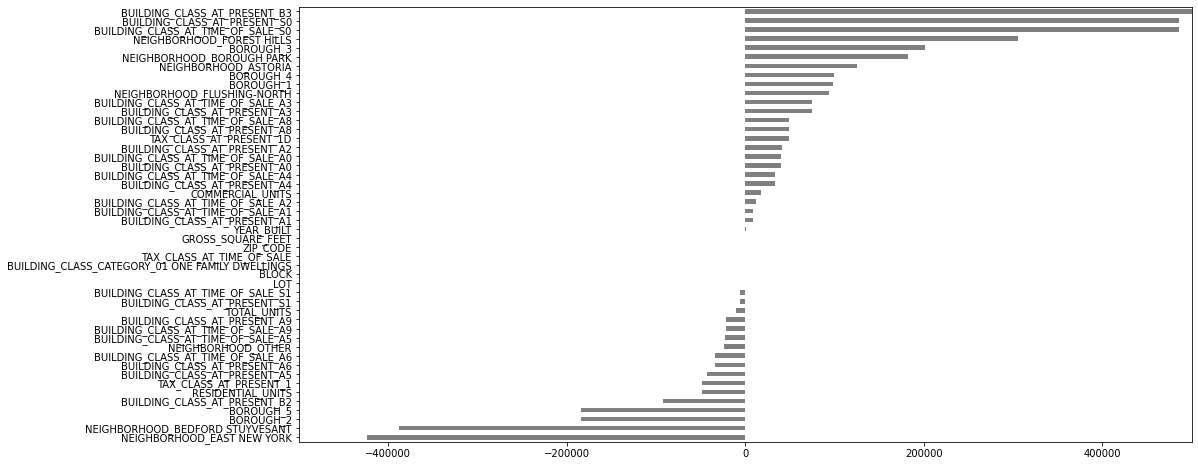

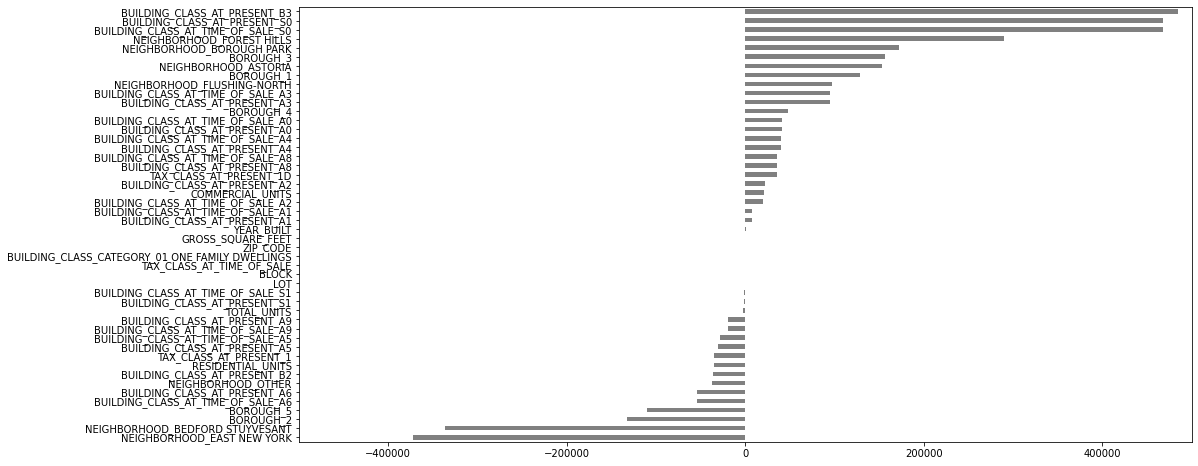

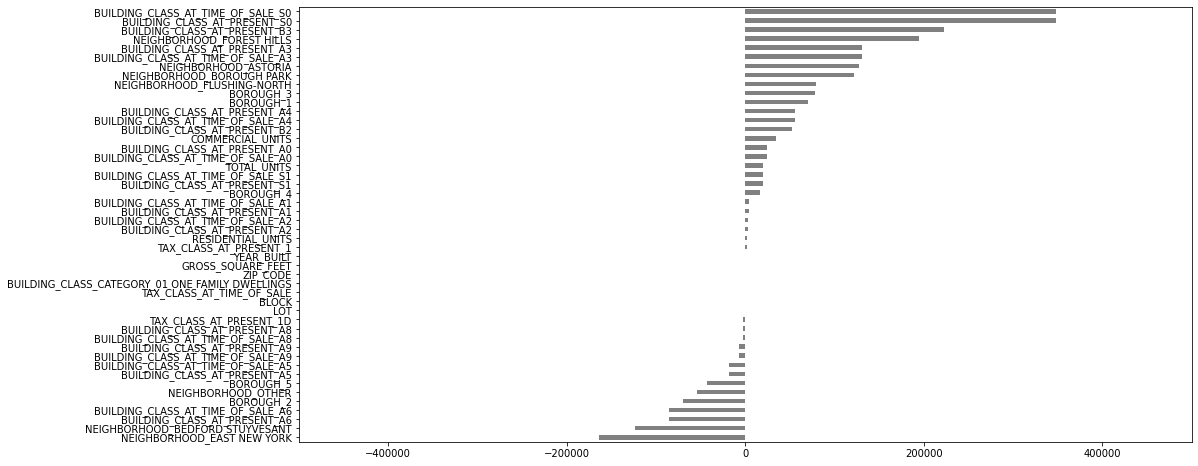

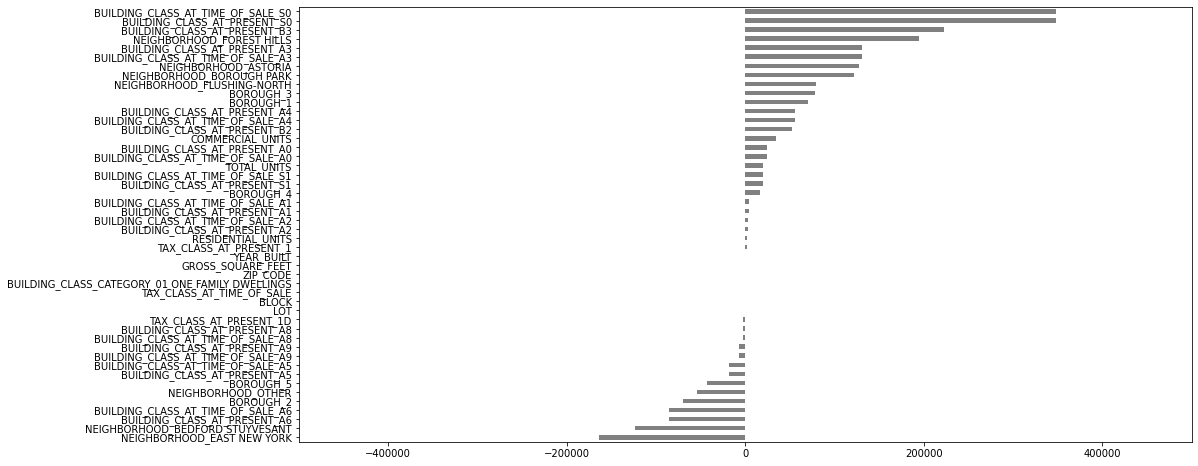

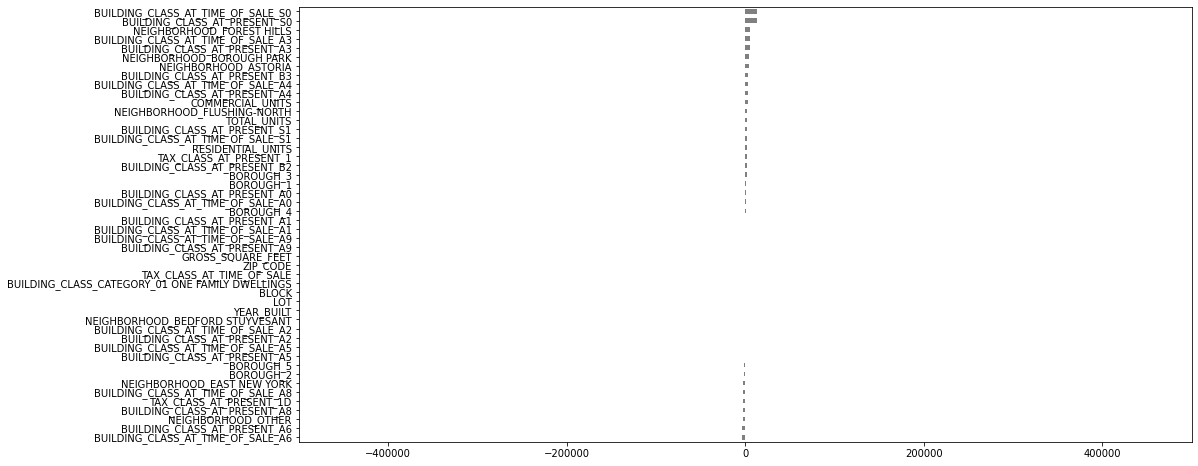

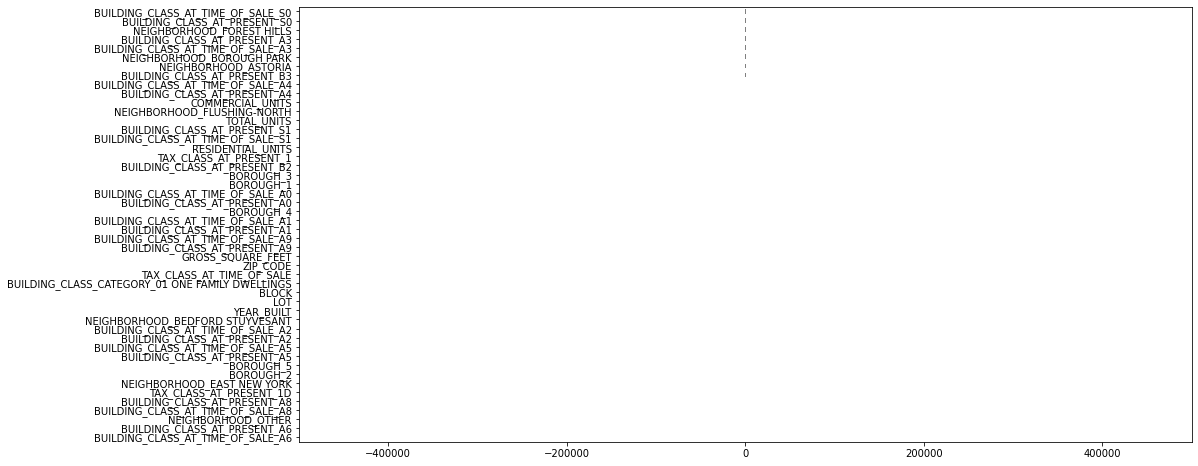

In [183]:
from sklearn.linear_model import Ridge
from IPython.display import display, HTML

for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_enc, y_train)
    y_pred = model.predict(X_test_enc)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train_enc.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-500000,500000)
    plt.show()